In [1]:
import torch_geometric as pyg
import torch
import numpy as np
import scanpy
from collections import defaultdict
import pickle
from torch_geometric.nn.models import Node2Vec
from torch_geometric.data import HeteroData, Data
from umap import UMAP

In [2]:
from matplotlib import cm

In [3]:
from util import to_homogeneous

In [4]:
import matplotlib.pyplot as plt

In [5]:
device='cuda:3'

graph = torch.load('input/pyg_graph.torch').to(device)
node_idxs = pickle.load(open('input/nodes_by_type.pickle','rb'))

In [6]:
graph.metadata()[1]

[('tad', 'overlaps', 'atac_region'),
 ('tad', 'overlaps', 'gene'),
 ('gene', 'associated', 'protein'),
 ('atac_region', 'overlaps', 'gene'),
 ('protein', 'coexpressed', 'protein'),
 ('protein', 'tf_interacts', 'gene'),
 ('protein', 'is_named', 'protein_name'),
 ('atac_region', 'neighbors', 'gene')]

In [7]:
metapaths = [
    ('gene', 'associated', 'protein'),
    ('protein', 'coexpressed', 'protein'),
    ('protein', 'tf_interacts', 'gene'),
    ('atac_region', 'overlaps', 'gene'),
    ('atac_region', 'neighbors', 'gene'),
]

In [8]:
subgraph = HeteroData()

for path in metapaths:
    subgraph[path].edge_index = graph[path].edge_index

subgraph['protein'].num_nodes = len(node_idxs['protein'])
subgraph['gene'].num_nodes = len(node_idxs['gene'])
subgraph['atac_region'].num_nodes = len(node_idxs['atac_region'])

In [9]:
for m in subgraph.metadata()[1]:
    src,t,dst = m
    print(src,t,dst)
    print(src,len(node_idxs[src]), float(len(subgraph[m].edge_index[0].unique())))
    print(dst,len(node_idxs[dst]), float(len(subgraph[m].edge_index[1].unique())))
    print('-')

gene associated protein
gene 9577 9577.0
protein 24591 9577.0
-
protein coexpressed protein
protein 24591 9321.0
protein 24591 9321.0
-
protein tf_interacts gene
protein 24591 738.0
gene 9577 1691.0
-
atac_region overlaps gene
atac_region 116465 8177.0
gene 9577 8410.0
-
atac_region neighbors gene
atac_region 116465 84850.0
gene 9577 9194.0
-


In [10]:
subgraph

HeteroData(
  protein={ num_nodes=24591 },
  gene={ num_nodes=9577 },
  atac_region={ num_nodes=116465 },
  (gene, associated, protein)={ edge_index=[2, 9577] },
  (protein, coexpressed, protein)={ edge_index=[2, 391642] },
  (protein, tf_interacts, gene)={ edge_index=[2, 6312] },
  (atac_region, overlaps, gene)={ edge_index=[2, 8410] },
  (atac_region, neighbors, gene)={ edge_index=[2, 144551] }
)

In [11]:
subgraph = to_homogeneous(subgraph, add_node_type=True, add_edge_type=True)

In [12]:
torch.save(subgraph, 'input/node2vec_subgraph.torch')

In [13]:
subgraph

Data(node_type=[150633], edge_index=[2, 560492], edge_type=[560492])

In [14]:
subgraph = subgraph.to('cpu')
subgraph = pyg.transforms.ToUndirected()(subgraph)

In [15]:
subgraph

Data(node_type=[150633], edge_index=[2, 713122], edge_type=[713122])

In [16]:
subgraph.num_nodes = len(subgraph.node_type)

In [17]:
subgraph.num_nodes

150633

In [18]:
model = Node2Vec(subgraph.edge_index, embedding_dim=128, walk_length=50,
                 context_size=25, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [19]:
def train():
    model.train()
    total_loss = 0
    for i,(pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
for epoch in range(1, 60):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 2.3846
Epoch: 02, Loss: 0.9175
Epoch: 03, Loss: 0.8126
Epoch: 04, Loss: 0.7871
Epoch: 05, Loss: 0.7798
Epoch: 06, Loss: 0.7783
Epoch: 07, Loss: 0.7784
Epoch: 08, Loss: 0.7791
Epoch: 09, Loss: 0.7800
Epoch: 10, Loss: 0.7809
Epoch: 11, Loss: 0.7814
Epoch: 12, Loss: 0.7816
Epoch: 13, Loss: 0.7816
Epoch: 14, Loss: 0.7814
Epoch: 15, Loss: 0.7812
Epoch: 16, Loss: 0.7810
Epoch: 17, Loss: 0.7808
Epoch: 18, Loss: 0.7807
Epoch: 19, Loss: 0.7806
Epoch: 20, Loss: 0.7806
Epoch: 21, Loss: 0.7805
Epoch: 22, Loss: 0.7803
Epoch: 23, Loss: 0.7803
Epoch: 24, Loss: 0.7802
Epoch: 25, Loss: 0.7802


In [27]:
node_types = subgraph._node_type_names

In [28]:
z=None
with torch.no_grad():
    model.eval()
    print('running model')
    z = model(torch.arange(subgraph.num_nodes, device=device))
    

running model


In [29]:
print('sampling')
N = 10000
sample = torch.randint(low=0, high=len(z), size=(N,))
q = z[sample]
print('umap')
q = UMAP(n_jobs=42, n_neighbors=200).fit_transform(q.cpu().numpy())

sampling
umap


plotting


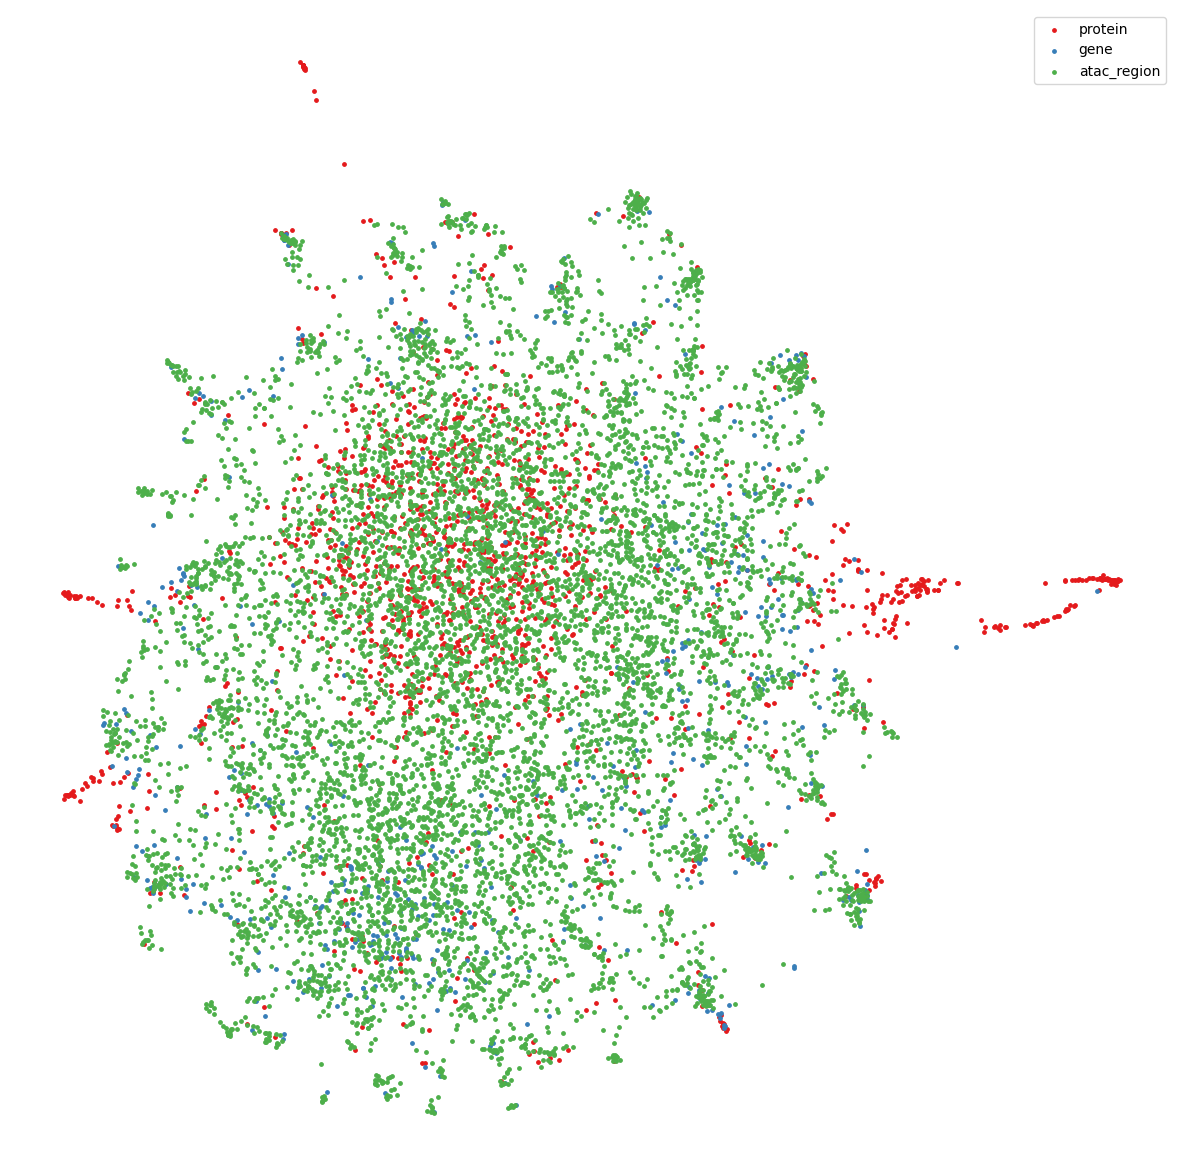

In [30]:
print('plotting')
fig = plt.figure(figsize=(15,15))
ax = plt.axes()
ax.axis('off')
cmap = cm.Set1(list(range(len(node_types))))
for i,node_type in enumerate(node_types):
    p = q[subgraph.node_type[sample]==i] #
    ax.scatter(p[:,0], p[:,1], alpha=1, s=6, color=cmap[i], label=node_type)
_=ax.legend()

In [31]:
embedding = model(torch.arange(subgraph.num_nodes, device=device))

In [32]:
torch.save(embedding, 'input/node2vec_embeddings.torch')